In [1]:
import tifffile as tf
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import mapping
from rasterio.windows import Window

datadir = 'C:/Users/jtrum/world_bank/data/'
wsf = tf.imread(datadir + 'WSF2019_v1_12_-10.tif')
aoi = gpd.read_file(datadir + 'luanda2clean.shp')

In [29]:
# Open the TIFF image
with rio.open('C:/Users/jtrum/world_bank/data/WSF2019_v1_12_-10.tif') as src:
    luanda_bbox = aoi.total_bounds # Get the bounding box of Luanda
    window = src.window(*luanda_bbox) # Calculate the window for cropping
    cropped_data = src.read(1, window=window)  # Read the data from the window

# Ensure that only 0 and 255 values are retained
cropped_data[cropped_data != 0] = 255

In [30]:
# Replace 'input.tif' with your input TIFF file and 'output.tif' with the desired output file name.
input_tiff_path = datadir + 'wsf2019.tif'
output_tiff_path = datadir + 'output.tif'

# Load the input TIFF file
with rio.open(input_tiff_path) as src:
    # Define CRS (Coordinate Reference System) for the output file
    crs = src.crs

    # Define geotransform parameters (affine transformation)
    # You may need to adjust these based on your specific data
    # (left, top), (x_resolution, y_resolution)
    transform = from_origin(src.bounds.left, src.bounds.top, src.res[0], src.res[1])

    # Create a new GeoTIFF file with CRS and transform
    with rio.open(output_tiff_path, 'w', driver='GTiff', width=src.width, height=src.height,
                       count=src.count, dtype=src.dtypes[0], crs=crs, transform=transform) as dst:
        # Copy the data from the input TIFF to the output TIFF
        dst.write(src.read())

print(f"GeoTIFF file with CRS and transform created: {output_tiff_path}")


GeoTIFF file with CRS and transform created: C:/Users/jtrum/world_bank/data/output.tif


In [4]:
# Count the occurrences of each unique value
unique_values, value_counts = np.unique(ws, return_counts=True)

# Print the unique values and their counts
for value, count in zip(unique_values, value_counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 50776044
Value: 255, Count: 5495036


In [5]:
wsf2019 = tf.imread(datadir + 'wsf2019.tif')
wsf2019.shape

(850, 771)

In [10]:
import matplotlib.pyplot as plt

In [21]:
wsf2019

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

<Axes: >

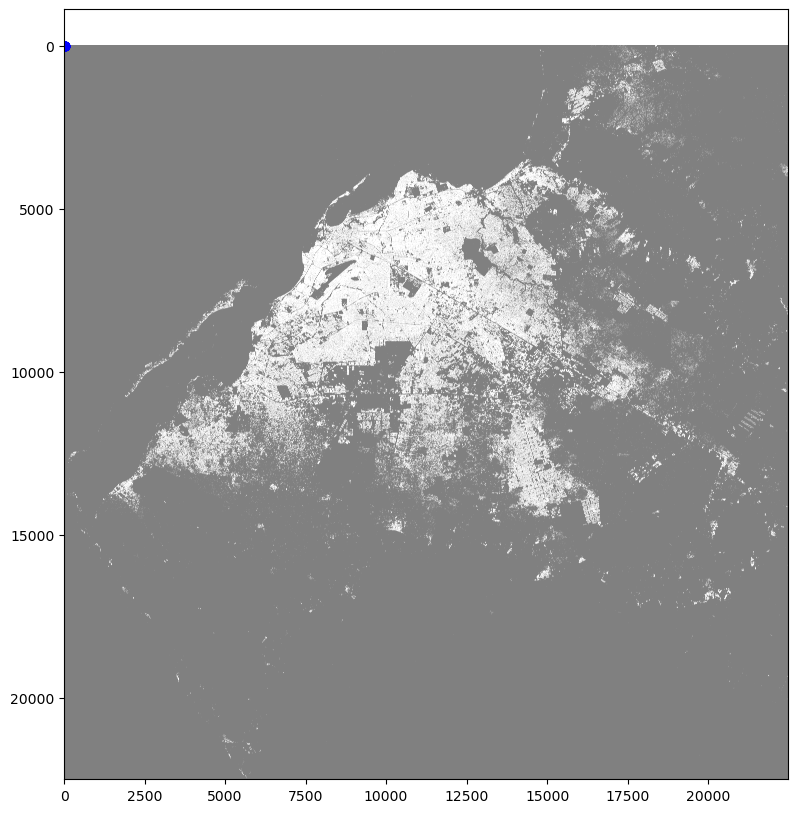

In [20]:
# make a plot of the aoi with the tiff data overlaid
fig, ax = plt.subplots(figsize=(10, 10))
aoi.plot(ax=ax, color='red')
show(wsf2019, ax=ax, cmap='gray', alpha=0.5)
water_infrastructure.plot(ax=ax, color='blue', alpha=0.5)


In [8]:
# export the cropped data as a GeoTIFF
with rio.open('C:/Users/jtrum/world_bank/data/wsf2019.tif', 'w', **src.profile) as dest:
    dest.write(cropped_data, 1)

In [13]:
import osmnx as ox

In [15]:
tags_list = [
    {'landuse': ['reservoir', 'basin']},
    {'amenity': ['drinking_water', 'watering_place', 'water_point']},
    {'man_made': ['water_well', 'water_tower', 'water_works', 'reservoir_covered', 'storage_tank', 'monitoring_station', 'wastewater_plant', 'watermill', 'pipeline']}
]        

water_infrastructure = pd.DataFrame(columns=['feature', 'geometry'])

for tags in tags_list:
    data = ox.geometries_from_polygon(aoi.geometry[0], tags=tags)
    data = data[['geometry']]
    data['feature'] = list(tags.keys())[0]  # Extract the feature type from the tags
    water_infrastructure = water_infrastructure.append(data)

water_infrastructure = water_infrastructure.reset_index(drop=True)
water_infrastructure = gpd.GeoDataFrame(water_infrastructure, geometry='geometry', crs=aoi.crs)

C:\Users\jtrum\AppData\Local\Temp\ipykernel_25404\1104742602.py:10: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  data = ox.geometries_from_polygon(aoi.geometry[0], tags=tags)
C:\Users\jtrum\AppData\Local\Temp\ipykernel_25404\1104742602.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  water_infrastructure = water_infrastructure.append(data)
c:\Users\jtrum\miniconda3\envs\wash_scan\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
C:\Users\jtrum\AppData\Local\Temp\ipykernel_25404\1104742602.py:10: UserWarning: The `geometries` module and `geome

In [16]:
water_infrastructure

,feature,geometry
0,landuse,"POLYGON ((13.37171 -8.96650, 13.37154 -8.96654..."
1,landuse,"POLYGON ((13.42644 -8.96246, 13.42685 -8.96349..."
2,landuse,"POLYGON ((13.32465 -8.87447, 13.32464 -8.87460..."
3,landuse,"POLYGON ((13.40856 -9.12585, 13.40885 -9.12606..."
4,landuse,"POLYGON ((13.41248 -9.12853, 13.41237 -9.12871..."
...,...,...
67,man_made,POINT (13.41021 -9.02977)
68,man_made,POINT (13.40010 -9.06025)
69,man_made,"POLYGON ((13.41069 -9.04171, 13.41066 -9.04166..."
70,man_made,"POLYGON ((13.41041 -9.15145, 13.40960 -9.15160..."


In [19]:
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS


GeoTIFF file with CRS and transform created: C:/Users/jtrum/world_bank/data/output.tif


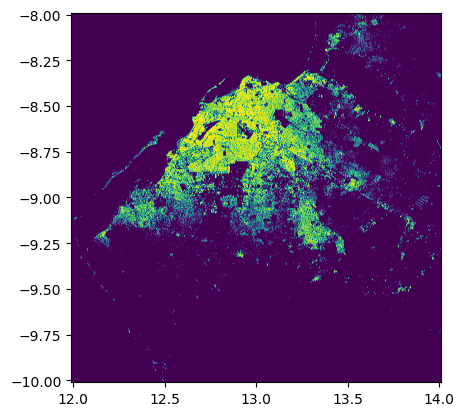

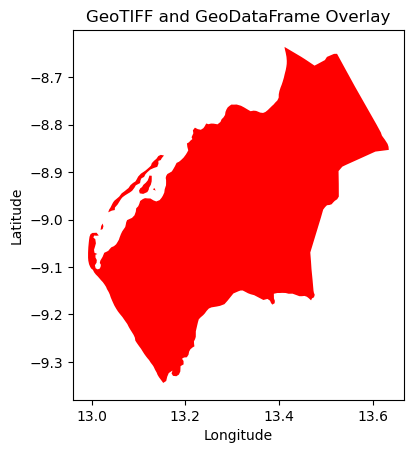

In [25]:
# Load the TIFF file
with rasterio.open(datadir + 'output.tif') as src:
    # Display the TIFF file using rasterio's show function
    show(src)

# Overlay the GeoDataFrame on the plot
aoi.plot(ax=plt.gca(), color='red', markersize=5)

# Add titles and labels if needed
plt.title("GeoTIFF and GeoDataFrame Overlay")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

<Axes: >

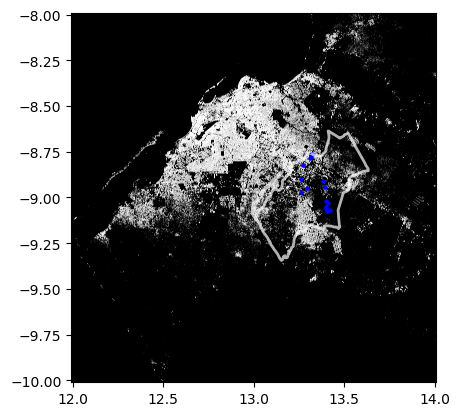

In [28]:
# Load the GeoTIFF file
with rasterio.open(datadir + 'output.tif') as src:
    # Plot the GeoTIFF in grayscale
    show(src, cmap='gray', ax=plt.gca())

    # Overlay the AOI outline in white with transparent background
    aoi = aoi.to_crs(src.crs)
    aoi.boundary.plot(ax=plt.gca(), color='white', linewidth=2, alpha=0.7)

# Plot the 'water_infrastructure' GeoDataFrame in blue
water_infrastructure.plot(ax=plt.gca(), color='blue', markersize=5)

In [26]:
show(src)

RasterioIOError: Dataset is closed: C:/Users/jtrum/world_bank/data/output.tif

In [34]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import numpy as np

# Load the GeoJSON as a GeoDataFrame
aoi = gpd.read_file(datadir + 'luanda2clean.geojson')

# Open the GeoTIFF file using rasterio
with rasterio.open(datadir + 'WSF2019_v1_12_-10.tif') as src:
    # Crop the GeoTIFF to the GeoJSON extent
    out_image, out_transform = mask(src, aoi.geometry, crop=True)
    out_meta = src.meta.copy()

# Create a binary mask for the GeoTIFF values (0 or 255)
binary_mask = (out_image == 0) | (out_image == 255)

# Update the metadata to reflect the new cropped extent
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform,
                 "nodata": np.nan})

# Save the cropped GeoTIFF with preserved binarized values
with rasterio.open('cropped_wsf.tif', 'w', **out_meta) as dst:
    dst.write(out_image)

# Now you have 'cropped_wsf.tif' with the cropped extent and NaN values for masked areas.
# You can use this GeoTIFF for further processing and overlay it with other data.


ValueError: Given nodata value, nan, is beyond the valid range of its data type, uint8.